In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/dataset/FINALDATASET 6.csv')

print(data.head)

<bound method NDFrame.head of     Company     Year  Market Share  Units Sold  Revenue  YoY Growth  Sales  \
0      Boat  2023 Q1           6.2       53000     11.5    0.000000   10.0   
1      Boat  2023 Q2           7.4       47567     12.4  -10.250943   11.3   
2      Boat  2023 Q3           9.8       61987     10.9   30.315134   12.1   
3      Boat  2023 Q4           3.9       56450     13.1   -8.932518    9.3   
4      Boat  2024 Q1           5.4       65032     11.7   15.202834   11.0   
5    Huawei  2023 Q1           6.1       10923      3.4    0.000000    3.0   
6    Huawei  2023 Q2           7.4        9873      4.5   -9.612744    3.4   
7    Huawei  2023 Q3           6.1       14322      5.0   45.062291    4.5   
8    Huawei  2023 Q4           7.4       18988      4.3   32.579249    2.3   
9    Huawei  2024 Q1           9.6       11232      4.9  -40.846851    1.2   
10  Samsung  2023 Q1           9.0       23442      6.7    0.000000    5.0   
11  Samsung  2023 Q2           7.4

In [ ]:
import pandas as pd
data = pd.get_dummies(data, columns=['Company'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Verify correct column names and check for numeric values
print(data.columns)  # Print column names to verify



Index(['Company', 'Year', 'Market Share', 'Units Sold', 'Revenue',
       'YoY Growth', 'Sales', 'CVP'],
      dtype='object')


In [ ]:
# Check for non-numeric columns
print(data[['Market Share', 'Units Sold', 'Revenue', 'YoY Growth', 'Sales', 'CVP']].dtypes)



Market Share    float64
Units Sold        int64
Revenue         float64
YoY Growth      float64
Sales           float64
CVP               int64
dtype: object


In [ ]:
# Scale the numeric columns
scaled_data = scaler.fit_transform(data[['Market Share', 'Units Sold', 'Revenue', 'YoY Growth', 'Sales', 'CVP']])

# Replace original columns with scaled data
data[['Market Share', 'Units Sold', 'Revenue', 'YoY Growth', 'Sales', 'CVP']] = scaled_data

# View the scaled data
print(data.head())

      Year  Market Share  Units Sold   Revenue  YoY Growth     Sales  \
0  2023 Q1      0.050885    0.781867  0.244713    0.411943  0.792793   
1  2023 Q2      0.077434    0.683370  0.271903    0.308561  0.909910   
2  2023 Q3      0.130531    0.944796  0.226586    0.717673  0.981982   
3  2023 Q4      0.000000    0.844413  0.293051    0.321858  0.729730   
4  2024 Q1      0.033186    1.000000  0.250755    0.565264  0.882883   

        CVP  Company_Apple  Company_Boat  Company_Huawei  Company_Others  \
0  0.714286          False          True           False           False   
1  0.857143          False          True           False           False   
2  0.714286          False          True           False           False   
3  1.000000          False          True           False           False   
4  1.000000          False          True           False           False   

   Company_Samsung  Company_Xiaomi  
0            False           False  
1            False           False  

In [ ]:
data.set_index('Year', inplace=True)  # Set 'Date' as the index

print(data.head())  # Check the scaled data

         Market Share  Units Sold   Revenue  YoY Growth     Sales       CVP  \
Year                                                                          
2023 Q1      0.050885    0.781867  0.244713    0.411943  0.792793  0.714286   
2023 Q2      0.077434    0.683370  0.271903    0.308561  0.909910  0.857143   
2023 Q3      0.130531    0.944796  0.226586    0.717673  0.981982  0.714286   
2023 Q4      0.000000    0.844413  0.293051    0.321858  0.729730  1.000000   
2024 Q1      0.033186    1.000000  0.250755    0.565264  0.882883  1.000000   

         Company_Apple  Company_Boat  Company_Huawei  Company_Others  \
Year                                                                   
2023 Q1          False          True           False           False   
2023 Q2          False          True           False           False   
2023 Q3          False          True           False           False   
2023 Q4          False          True           False           False   
2024 Q1       

In [ ]:
import numpy as np

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Use past time_step data as features
        y.append(data[i + time_step, 0])      # Predict next value (e.g., market_share)
    return np.array(X), np.array(y)

# Assume you're focusing on market_share prediction
features = data[['Market Share', 'Units Sold', 'Revenue', 'YoY Growth', 'Sales', 'CVP']].values
time_step = 3  # Use the past 3 years to predict the next
X, y = create_dataset(features, time_step)

# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

print(X.shape, y.shape)  # Check the shapes of input and output arrays


(27, 3, 6) (27,)


In [ ]:
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape)  # Check training and testing shapes


(21, 3, 6) (6, 3, 6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(50, return_sequences=False))  # Second LSTM layer
model.add(Dense(25))  # Dense layer with 25 units
model.add(Dense(1))   # Output layer with 1 unit (predicting next market_share)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.0354 - val_loss: 0.7243
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0280 - val_loss: 0.6608
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0237 - val_loss: 0.6060
Epoch 4/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0207 - val_loss: 0.5620
Epoch 5/50
1/1 [==============================] - 0s 44ms/step - loss: 0.0200 - val_loss: 0.5321
Epoch 6/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0228 - val_loss: 0.5192
Epoch 7/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0215 - val_loss: 0.5178
Epoch 8/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0227 - val_loss: 0.5257
Epoch 9/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0216 - val_loss: 0.5398
Epoch 10/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0203 - val_loss: 0.5577
Epoch 11/50
1/1 [==============

1/1 [==============================] - 1s 1s/step


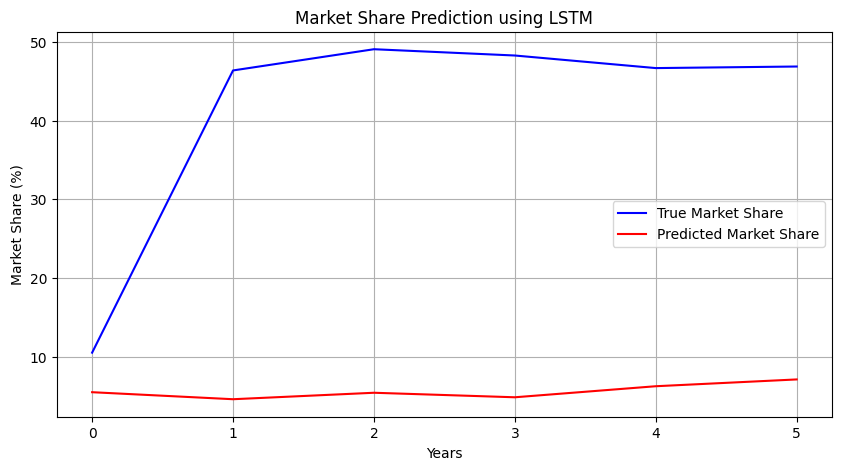

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_test)

# Create an empty array with the correct shape for inverse transformation
predictions_reshaped = np.zeros((predictions.shape[0], X.shape[2]))

# Put the predictions back in the first column
predictions_reshaped[:, 0] = predictions.flatten()

# Inverse transform using the original scaler
predictions = scaler.inverse_transform(predictions_reshaped)

# Reshape y_test to have the same number of columns as the original data
y_test_reshaped = np.zeros((y_test.shape[0], X.shape[2]))
y_test_reshaped[:, 0] = y_test.flatten()

# Inverse scaling for true values
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled[:, 0], label='True Market Share', color='blue')
plt.plot(predictions[:, 0], label='Predicted Market Share', color='red')
plt.title('Market Share Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('Market Share (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions[:, 4]))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.48159975152865464
